<a href="https://colab.research.google.com/github/bhomaidan1990/SSI_Project/blob/master/MultiClass_Segmentation_SSI_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiClass Segmentation using pretrained model

### Import necssary libraries

In [0]:
!pip install segmentation_models
#----------------------------------
import random
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## Mount Google Drive to read Dataset

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


### Initialization

In [0]:
#--------------------------------------
# For reproducabilty
seed = 42
np.random.seed = seed
tf.random.set_seed = seed
#--------------------------------------
# Check if there is valid GPU to be used
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('GPU is Availabele cool...')
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    print('Warning ... you are working on CPU, it will take ages!')
#--------------------------------------
# BACKBONE = 'resnet34'
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

GPU is Availabele cool...


### Loading the Data

  2%|▎         | 1/40 [00:01<00:44,  1.15s/it]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 15
9 17
10 19
11 21
12 23
13 24
14 25
15 26
16 28
17 32
18 38
19 40
20 42
21 43
22 45
23 47
24 49
25 51
26 57
27 59
28 60
29 61
30 62
31 66
32 68
33 71
34 78
35 79
36 80
37 81
38 82
39 83
40 85
41 86
42 87
43 89
44 90
45 91
46 93
47 94
48 95
49 97
50 98
51 102
52 106
53 109
54 119
55 121
56 123
57 125
58 127
59 128
60 129
61 130
62 132
63 135
64 136
65 137
66 153
67 157
68 161
69 163
70 165
71 166
72 168
73 169
74 170
75 172
76 174
77 175
78 176
79 177
80 178
81 181
82 191
83 193
84 194
85 195
86 196
87 198
88 203
89 204
90 206
91 208
92 210
93 212
94 213
95 215
96 221
97 229
98 231
99 232
100 233
101 234
102 236
103 237
104 238
105 242
106 246
107 247
108 248
109 249
110 250
111 251
112 252
113 253
114 254
115 255


  5%|▌         | 2/40 [00:02<00:41,  1.09s/it]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 11
8 13
9 15
10 19
11 21
12 22
13 23
14 24
15 25
16 26
17 30
18 34
19 40
20 41
21 42
22 43
23 45
24 47
25 51
26 52
27 53
28 54
29 59
30 60
31 61
32 62
33 64
34 66
35 75
36 76
37 77
38 78
39 79
40 80
41 81
42 83
43 85
44 86
45 87
46 89
47 90
48 91
49 92
50 93
51 94
52 96
53 98
54 106
55 111
56 115
57 119
58 123
59 127
60 128
61 129
62 131
63 132
64 135
65 136
66 137
67 142
68 157
69 161
70 162
71 164
72 165
73 166
74 169
75 170
76 172
77 174
78 175
79 176
80 177
81 178
82 179
83 191
84 193
85 194
86 195
87 196
88 198
89 200
90 202
91 203
92 204
93 208
94 210
95 212
96 213
97 215
98 229
99 230
100 231
101 232
102 234
103 238
104 242
105 246
106 247
107 248
108 249
109 250
110 251
111 252
112 253
113 254
114 255


  8%|▊         | 3/40 [00:02<00:36,  1.01it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 11
10 13
11 17
12 21
13 22
14 23
15 24
16 25
17 26
18 28
19 32
20 33
21 36
22 40
23 42
24 43
25 45
26 47
27 51
28 52
29 53
30 54
31 57
32 59
33 60
34 61
35 62
36 64
37 66
38 70
39 74
40 78
41 79
42 80
43 81
44 83
45 85
46 86
47 88
48 89
49 90
50 91
51 92
52 93
53 94
54 95
55 97
56 98
57 103
58 109
59 118
60 119
61 123
62 125
63 127
64 128
65 129
66 130
67 131
68 132
69 136
70 142
71 144
72 153
73 157
74 159
75 161
76 162
77 165
78 166
79 168
80 169
81 170
82 172
83 174
84 175
85 176
86 177
87 179
88 189
89 191
90 193
91 194
92 195
93 196
94 202
95 203
96 204
97 208
98 210
99 212
100 213
101 215
102 225
103 229
104 230
105 231
106 232
107 237
108 240
109 242
110 244
111 246
112 248
113 249
114 250
115 251
116 252
117 253
118 254
119 255


 10%|█         | 4/40 [00:03<00:34,  1.05it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 11
10 13
11 14
12 15
13 19
14 21
15 23
16 24
17 25
18 26
19 28
20 33
21 40
22 42
23 43
24 45
25 47
26 50
27 51
28 52
29 54
30 59
31 60
32 61
33 62
34 64
35 70
36 71
37 72
38 77
39 78
40 79
41 80
42 81
43 83
44 85
45 86
46 87
47 89
48 90
49 91
50 92
51 93
52 94
53 98
54 106
55 119
56 121
57 123
58 125
59 127
60 131
61 132
62 135
63 136
64 141
65 144
66 145
67 153
68 157
69 159
70 161
71 165
72 166
73 168
74 169
75 170
76 171
77 172
78 174
79 175
80 176
81 177
82 179
83 183
84 189
85 191
86 193
87 194
88 195
89 196
90 200
91 202
92 204
93 206
94 208
95 210
96 212
97 213
98 215
99 217
100 229
101 230
102 231
103 232
104 235
105 236
106 238
107 241
108 242
109 244
110 246
111 247
112 248
113 249
114 250
115 251
116 252
117 253
118 254
119 255


 12%|█▎        | 5/40 [00:04<00:31,  1.11it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 13
9 14
10 17
11 18
12 23
13 24
14 25
15 26
16 36
17 40
18 41
19 42
20 43
21 45
22 47
23 51
24 55
25 59
26 60
27 61
28 62
29 64
30 66
31 70
32 78
33 79
34 80
35 81
36 83
37 85
38 86
39 87
40 89
41 90
42 91
43 94
44 95
45 97
46 98
47 119
48 123
49 127
50 130
51 132
52 136
53 146
54 157
55 160
56 161
57 162
58 164
59 165
60 166
61 168
62 169
63 170
64 172
65 174
66 175
67 176
68 177
69 179
70 189
71 191
72 193
73 194
74 195
75 196
76 203
77 204
78 208
79 210
80 212
81 213
82 215
83 225
84 227
85 229
86 230
87 231
88 232
89 234
90 236
91 242
92 244
93 246
94 248
95 249
96 250
97 251
98 253
99 254
100 255


 15%|█▌        | 6/40 [00:05<00:29,  1.13it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 11
9 13
10 14
11 15
12 17
13 19
14 20
15 21
16 23
17 24
18 25
19 26
20 28
21 32
22 40
23 42
24 43
25 45
26 47
27 51
28 54
29 55
30 58
31 59
32 60
33 61
34 62
35 71
36 72
37 74
38 76
39 77
40 78
41 79
42 80
43 81
44 82
45 83
46 85
47 86
48 87
49 89
50 90
51 91
52 93
53 94
54 97
55 98
56 110
57 119
58 121
59 123
60 126
61 127
62 129
63 130
64 131
65 132
66 135
67 136
68 142
69 146
70 147
71 149
72 153
73 157
74 159
75 161
76 165
77 166
78 167
79 168
80 169
81 170
82 171
83 172
84 174
85 175
86 176
87 177
88 184
89 193
90 194
91 196
92 198
93 201
94 203
95 204
96 208
97 210
98 212
99 215
100 217
101 223
102 227
103 229
104 231
105 232
106 235
107 236
108 240
109 241
110 242
111 246
112 248
113 249
114 250
115 251
116 252
117 253
118 254
119 255


 18%|█▊        | 7/40 [00:06<00:27,  1.18it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 21
9 23
10 24
11 25
12 26
13 28
14 30
15 34
16 40
17 42
18 43
19 45
20 47
21 51
22 55
23 59
24 60
25 61
26 62
27 64
28 66
29 68
30 70
31 75
32 76
33 78
34 79
35 80
36 81
37 83
38 85
39 86
40 87
41 89
42 90
43 91
44 93
45 94
46 95
47 97
48 98
49 99
50 106
51 108
52 119
53 120
54 122
55 123
56 125
57 127
58 128
59 130
60 132
61 136
62 157
63 158
64 160
65 161
66 162
67 164
68 165
69 166
70 168
71 169
72 170
73 172
74 174
75 175
76 176
77 177
78 178
79 179
80 191
81 193
82 194
83 195
84 196
85 200
86 202
87 203
88 204
89 208
90 210
91 212
92 213
93 215
94 229
95 230
96 231
97 232
98 237
99 242
100 246
101 248
102 249
103 250
104 251
105 252
106 253
107 254
108 255


 20%|██        | 8/40 [00:06<00:26,  1.21it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 11
9 13
10 23
11 24
12 25
13 26
14 28
15 38
16 40
17 41
18 42
19 43
20 45
21 47
22 49
23 51
24 52
25 55
26 59
27 60
28 61
29 62
30 64
31 66
32 68
33 70
34 75
35 76
36 78
37 79
38 80
39 81
40 83
41 85
42 86
43 88
44 89
45 90
46 91
47 92
48 93
49 94
50 98
51 106
52 108
53 119
54 123
55 125
56 127
57 128
58 130
59 131
60 132
61 133
62 135
63 136
64 140
65 153
66 157
67 158
68 161
69 162
70 164
71 165
72 166
73 168
74 169
75 170
76 172
77 174
78 175
79 176
80 177
81 189
82 193
83 194
84 195
85 196
86 197
87 200
88 203
89 204
90 206
91 208
92 210
93 212
94 213
95 215
96 229
97 230
98 231
99 232
100 234
101 242
102 246
103 247
104 248
105 249
106 250
107 251
108 253
109 254
110 255


 22%|██▎       | 9/40 [00:07<00:24,  1.26it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 17
9 18
10 19
11 21
12 23
13 24
14 25
15 26
16 28
17 30
18 34
19 40
20 42
21 43
22 45
23 47
24 49
25 51
26 52
27 54
28 57
29 59
30 60
31 61
32 62
33 72
34 74
35 77
36 78
37 79
38 80
39 81
40 82
41 83
42 85
43 86
44 87
45 89
46 90
47 91
48 92
49 93
50 94
51 95
52 97
53 98
54 106
55 109
56 119
57 121
58 123
59 127
60 132
61 133
62 136
63 140
64 157
65 161
66 164
67 165
68 166
69 168
70 169
71 170
72 172
73 174
74 175
75 176
76 177
77 184
78 191
79 193
80 194
81 195
82 196
83 202
84 203
85 204
86 208
87 210
88 212
89 213
90 215
91 217
92 225
93 229
94 230
95 231
96 232
97 234
98 236
99 238
100 242
101 246
102 248
103 249
104 250
105 251
106 252
107 253
108 254
109 255


 25%|██▌       | 10/40 [00:08<00:23,  1.27it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 17
9 21
10 23
11 24
12 25
13 26
14 32
15 34
16 40
17 42
18 43
19 45
20 47
21 49
22 51
23 52
24 53
25 57
26 58
27 59
28 60
29 61
30 62
31 64
32 68
33 72
34 74
35 77
36 78
37 79
38 80
39 81
40 82
41 83
42 85
43 86
44 87
45 89
46 90
47 91
48 92
49 93
50 94
51 95
52 97
53 98
54 102
55 109
56 119
57 123
58 125
59 126
60 127
61 129
62 132
63 134
64 136
65 153
66 157
67 159
68 161
69 164
70 165
71 166
72 168
73 169
74 170
75 171
76 172
77 174
78 175
79 176
80 178
81 179
82 193
83 194
84 195
85 196
86 200
87 204
88 208
89 210
90 212
91 213
92 215
93 227
94 229
95 230
96 231
97 234
98 238
99 240
100 242
101 246
102 247
103 248
104 249
105 250
106 251
107 253
108 254
109 255


 28%|██▊       | 11/40 [00:09<00:23,  1.25it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 15
10 23
11 24
12 25
13 26
14 40
15 41
16 42
17 43
18 45
19 47
20 51
21 59
22 60
23 61
24 62
25 78
26 79
27 80
28 81
29 83
30 85
31 86
32 89
33 90
34 94
35 98
36 118
37 119
38 123
39 125
40 126
41 127
42 128
43 131
44 132
45 136
46 153
47 157
48 161
49 165
50 166
51 169
52 170
53 172
54 174
55 175
56 176
57 177
58 179
59 181
60 191
61 193
62 194
63 195
64 196
65 203
66 204
67 208
68 210
69 212
70 213
71 215
72 229
73 230
74 231
75 232
76 233
77 242
78 244
79 246
80 248
81 249
82 250
83 251
84 253
85 254
86 255


 30%|███       | 12/40 [00:10<00:24,  1.16it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 13
10 17
11 21
12 23
13 24
14 25
15 26
16 28
17 38
18 40
19 42
20 43
21 45
22 47
23 51
24 52
25 55
26 59
27 60
28 61
29 62
30 64
31 70
32 76
33 77
34 78
35 79
36 80
37 81
38 82
39 83
40 85
41 86
42 89
43 90
44 93
45 94
46 98
47 108
48 110
49 118
50 119
51 123
52 127
53 132
54 146
55 153
56 157
57 161
58 165
59 166
60 169
61 170
62 172
63 174
64 175
65 176
66 177
67 193
68 194
69 195
70 196
71 198
72 208
73 210
74 212
75 213
76 215
77 229
78 230
79 231
80 232
81 234
82 242
83 244
84 246
85 248
86 249
87 250
88 251
89 253
90 254
91 255


 32%|███▎      | 13/40 [00:11<00:22,  1.19it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 14
9 17
10 21
11 23
12 24
13 25
14 26
15 38
16 40
17 42
18 43
19 45
20 47
21 51
22 52
23 59
24 60
25 61
26 62
27 71
28 76
29 77
30 78
31 79
32 80
33 81
34 83
35 85
36 86
37 89
38 90
39 91
40 94
41 98
42 115
43 119
44 123
45 125
46 127
47 128
48 130
49 132
50 134
51 136
52 142
53 153
54 157
55 161
56 163
57 165
58 166
59 169
60 170
61 172
62 174
63 175
64 176
65 177
66 184
67 193
68 194
69 195
70 196
71 204
72 208
73 210
74 212
75 215
76 229
77 231
78 232
79 235
80 237
81 241
82 242
83 246
84 248
85 249
86 250
87 251
88 253
89 254
90 255


 35%|███▌      | 14/40 [00:11<00:21,  1.18it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 11
8 13
9 14
10 19
11 21
12 23
13 24
14 25
15 26
16 38
17 40
18 42
19 43
20 45
21 47
22 51
23 52
24 59
25 60
26 61
27 62
28 71
29 74
30 77
31 78
32 79
33 80
34 81
35 83
36 84
37 85
38 86
39 87
40 89
41 90
42 94
43 95
44 98
45 118
46 119
47 121
48 123
49 127
50 132
51 136
52 153
53 157
54 161
55 162
56 163
57 165
58 169
59 170
60 172
61 174
62 175
63 176
64 177
65 184
66 193
67 194
68 195
69 203
70 204
71 208
72 210
73 212
74 213
75 215
76 229
77 231
78 232
79 235
80 236
81 241
82 242
83 246
84 248
85 249
86 250
87 251
88 253
89 254
90 255


 38%|███▊      | 15/40 [00:12<00:21,  1.15it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 23
9 24
10 25
11 26
12 40
13 42
14 43
15 45
16 47
17 51
18 59
19 60
20 61
21 62
22 74
23 76
24 78
25 79
26 80
27 81
28 83
29 85
30 86
31 89
32 90
33 94
34 95
35 98
36 118
37 119
38 123
39 127
40 129
41 132
42 136
43 141
44 153
45 157
46 161
47 162
48 165
49 166
50 169
51 170
52 172
53 174
54 175
55 176
56 177
57 179
58 193
59 194
60 195
61 196
62 198
63 204
64 206
65 208
66 210
67 212
68 213
69 215
70 229
71 230
72 231
73 232
74 234
75 242
76 246
77 248
78 249
79 250
80 251
81 252
82 253
83 254
84 255


 40%|████      | 16/40 [00:13<00:20,  1.17it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 11
8 13
9 14
10 19
11 20
12 22
13 23
14 24
15 25
16 26
17 40
18 42
19 43
20 45
21 47
22 51
23 52
24 59
25 60
26 61
27 62
28 71
29 76
30 78
31 79
32 80
33 81
34 83
35 85
36 86
37 89
38 90
39 91
40 94
41 98
42 118
43 119
44 121
45 123
46 127
47 132
48 136
49 153
50 157
51 161
52 165
53 166
54 169
55 170
56 172
57 174
58 175
59 176
60 177
61 180
62 184
63 189
64 191
65 193
66 194
67 195
68 196
69 198
70 201
71 203
72 204
73 210
74 212
75 213
76 215
77 229
78 230
79 231
80 232
81 241
82 242
83 246
84 248
85 249
86 250
87 251
88 252
89 253
90 254
91 255


 42%|████▎     | 17/40 [00:14<00:20,  1.12it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 14
9 17
10 21
11 23
12 24
13 25
14 26
15 32
16 40
17 42
18 43
19 45
20 47
21 51
22 57
23 59
24 60
25 61
26 62
27 71
28 78
29 79
30 80
31 81
32 82
33 83
34 85
35 86
36 89
37 90
38 93
39 94
40 98
41 115
42 118
43 119
44 123
45 127
46 128
47 132
48 136
49 146
50 153
51 157
52 161
53 165
54 166
55 169
56 170
57 172
58 174
59 175
60 176
61 177
62 179
63 184
64 189
65 193
66 194
67 195
68 196
69 201
70 203
71 204
72 208
73 210
74 212
75 229
76 230
77 231
78 232
79 234
80 235
81 241
82 242
83 246
84 248
85 249
86 250
87 251
88 253
89 254
90 255


 45%|████▌     | 18/40 [00:15<00:19,  1.15it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 17
9 21
10 23
11 24
12 25
13 26
14 32
15 40
16 42
17 43
18 45
19 47
20 51
21 59
22 60
23 61
24 62
25 71
26 77
27 78
28 79
29 80
30 81
31 82
32 83
33 85
34 86
35 89
36 90
37 93
38 94
39 98
40 118
41 119
42 123
43 127
44 128
45 132
46 136
47 146
48 153
49 157
50 161
51 162
52 165
53 166
54 168
55 169
56 170
57 172
58 174
59 175
60 176
61 177
62 180
63 181
64 193
65 194
66 195
67 196
68 204
69 208
70 210
71 212
72 213
73 215
74 229
75 230
76 231
77 232
78 242
79 246
80 248
81 249
82 250
83 251
84 253
85 254
86 255


 48%|████▊     | 19/40 [00:16<00:17,  1.21it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 13
9 14
10 21
11 23
12 24
13 25
14 26
15 28
16 32
17 40
18 42
19 43
20 45
21 47
22 51
23 52
24 59
25 60
26 61
27 62
28 71
29 76
30 78
31 79
32 80
33 81
34 82
35 83
36 85
37 86
38 89
39 90
40 93
41 94
42 98
43 99
44 102
45 114
46 118
47 119
48 123
49 127
50 132
51 136
52 151
53 157
54 161
55 162
56 165
57 166
58 169
59 170
60 171
61 172
62 174
63 175
64 176
65 177
66 179
67 191
68 193
69 194
70 195
71 196
72 203
73 204
74 208
75 210
76 212
77 215
78 217
79 229
80 230
81 231
82 232
83 234
84 238
85 240
86 241
87 242
88 246
89 248
90 249
91 250
92 251
93 253
94 254
95 255


 50%|█████     | 20/40 [00:16<00:16,  1.24it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 17
10 21
11 22
12 23
13 24
14 25
15 26
16 40
17 42
18 43
19 45
20 47
21 51
22 59
23 60
24 61
25 62
26 64
27 70
28 77
29 78
30 79
31 80
32 81
33 82
34 83
35 85
36 86
37 89
38 90
39 94
40 98
41 118
42 119
43 123
44 127
45 130
46 132
47 136
48 157
49 161
50 162
51 163
52 165
53 166
54 169
55 170
56 172
57 173
58 174
59 175
60 176
61 177
62 178
63 179
64 191
65 193
66 194
67 195
68 196
69 203
70 204
71 208
72 210
73 212
74 213
75 215
76 229
77 230
78 231
79 232
80 234
81 236
82 238
83 242
84 246
85 248
86 249
87 250
88 251
89 253
90 254
91 255


 52%|█████▎    | 21/40 [00:17<00:15,  1.20it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 14
10 15
11 16
12 17
13 19
14 20
15 23
16 24
17 25
18 26
19 28
20 32
21 33
22 38
23 40
24 42
25 43
26 45
27 47
28 49
29 50
30 51
31 52
32 55
33 56
34 57
35 58
36 59
37 60
38 61
39 62
40 64
41 70
42 71
43 72
44 75
45 76
46 77
47 78
48 79
49 80
50 81
51 83
52 84
53 85
54 86
55 87
56 89
57 90
58 91
59 92
60 93
61 94
62 98
63 108
64 109
65 110
66 113
67 115
68 118
69 119
70 121
71 122
72 123
73 125
74 126
75 127
76 128
77 130
78 131
79 132
80 133
81 134
82 136
83 143
84 145
85 146
86 149
87 152
88 153
89 157
90 159
91 160
92 161
93 163
94 165
95 166
96 167
97 168
98 169
99 170
100 171
101 172
102 174
103 175
104 176
105 177
106 178
107 179
108 181
109 184
110 185
111 190
112 193
113 194
114 195
115 196
116 198
117 200
118 202
119 203
120 204
121 206
122 208
123 210
124 212
125 213
126 214
127 215
128 217
129 225
130 229
131 230
132 231
133 232
134 235
135 236
136 237
137 240
138 241
139 242
140 244
141 246
142 248
143 249
144 250
145 251
146 252


 55%|█████▌    | 22/40 [00:18<00:14,  1.21it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 13
9 14
10 15
11 16
12 17
13 19
14 20
15 23
16 24
17 25
18 26
19 30
20 34
21 36
22 38
23 40
24 42
25 43
26 45
27 47
28 50
29 51
30 52
31 53
32 54
33 55
34 57
35 59
36 60
37 61
38 62
39 64
40 68
41 70
42 71
43 72
44 76
45 77
46 78
47 79
48 80
49 81
50 83
51 84
52 85
53 86
54 87
55 88
56 89
57 90
58 91
59 92
60 93
61 94
62 96
63 98
64 110
65 112
66 115
67 118
68 119
69 121
70 123
71 125
72 127
73 128
74 129
75 130
76 132
77 134
78 136
79 140
80 141
81 143
82 145
83 146
84 147
85 149
86 151
87 152
88 153
89 157
90 158
91 159
92 160
93 161
94 162
95 163
96 164
97 165
98 166
99 167
100 168
101 169
102 170
103 172
104 174
105 175
106 176
107 177
108 178
109 179
110 181
111 184
112 185
113 187
114 189
115 193
116 194
117 195
118 196
119 197
120 200
121 202
122 203
123 204
124 208
125 210
126 212
127 213
128 214
129 215
130 217
131 221
132 225
133 227
134 229
135 230
136 231
137 232
138 234
139 235
140 236
141 237
142 238
143 240
144 241
145 242
146 244
1

 57%|█████▊    | 23/40 [00:19<00:14,  1.20it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 11
9 13
10 14
11 15
12 17
13 19
14 20
15 23
16 24
17 25
18 26
19 30
20 32
21 33
22 40
23 42
24 43
25 45
26 47
27 51
28 52
29 54
30 59
31 60
32 61
33 62
34 70
35 71
36 72
37 74
38 76
39 77
40 78
41 79
42 80
43 81
44 83
45 85
46 86
47 87
48 88
49 89
50 90
51 91
52 92
53 93
54 94
55 95
56 96
57 97
58 98
59 111
60 114
61 118
62 119
63 121
64 122
65 123
66 125
67 127
68 128
69 129
70 132
71 134
72 135
73 136
74 137
75 144
76 147
77 157
78 160
79 161
80 165
81 166
82 168
83 169
84 170
85 172
86 174
87 175
88 176
89 177
90 178
91 179
92 181
93 184
94 185
95 187
96 191
97 193
98 194
99 195
100 196
101 199
102 200
103 202
104 203
105 204
106 206
107 208
108 210
109 212
110 213
111 215
112 225
113 227
114 229
115 230
116 231
117 232
118 234
119 235
120 236
121 238
122 240
123 241
124 242
125 244
126 246
127 248
128 249
129 250
130 251
131 252
132 253
133 254
134 255


 60%|██████    | 24/40 [00:20<00:14,  1.10it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 11
9 12
10 13
11 14
12 15
13 18
14 19
15 20
16 23
17 24
18 25
19 26
20 32
21 33
22 36
23 38
24 40
25 42
26 43
27 45
28 47
29 51
30 52
31 54
32 56
33 59
34 60
35 61
36 62
37 66
38 70
39 71
40 72
41 76
42 77
43 78
44 79
45 80
46 81
47 83
48 85
49 86
50 87
51 89
52 90
53 93
54 94
55 98
56 102
57 111
58 118
59 119
60 121
61 122
62 123
63 125
64 126
65 127
66 128
67 131
68 132
69 134
70 136
71 141
72 144
73 145
74 146
75 157
76 158
77 159
78 160
79 161
80 162
81 163
82 165
83 166
84 167
85 168
86 169
87 170
88 172
89 174
90 175
91 176
92 177
93 178
94 179
95 181
96 184
97 185
98 187
99 189
100 193
101 194
102 195
103 196
104 198
105 201
106 202
107 204
108 208
109 210
110 212
111 213
112 215
113 217
114 222
115 223
116 225
117 229
118 230
119 231
120 232
121 234
122 235
123 236
124 237
125 238
126 239
127 240
128 241
129 242
130 244
131 246
132 248
133 249
134 250
135 251
136 253
137 254
138 255


 62%|██████▎   | 25/40 [00:21<00:13,  1.10it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 11
10 13
11 14
12 17
13 19
14 20
15 23
16 24
17 25
18 26
19 28
20 32
21 36
22 38
23 40
24 42
25 43
26 45
27 47
28 49
29 51
30 52
31 55
32 59
33 60
34 61
35 62
36 64
37 70
38 71
39 72
40 75
41 76
42 77
43 78
44 79
45 80
46 81
47 83
48 85
49 86
50 87
51 89
52 90
53 91
54 92
55 94
56 98
57 103
58 109
59 119
60 120
61 121
62 122
63 123
64 125
65 127
66 128
67 132
68 134
69 136
70 140
71 143
72 146
73 151
74 153
75 157
76 158
77 159
78 161
79 162
80 164
81 165
82 166
83 168
84 169
85 170
86 171
87 172
88 173
89 174
90 175
91 176
92 177
93 178
94 179
95 180
96 181
97 182
98 184
99 185
100 186
101 187
102 189
103 191
104 193
105 194
106 195
107 196
108 198
109 200
110 201
111 202
112 204
113 205
114 208
115 210
116 212
117 213
118 215
119 217
120 221
121 222
122 223
123 229
124 230
125 231
126 232
127 234
128 235
129 236
130 239
131 240
132 241
133 242
134 243
135 246
136 248
137 249
138 250
139 251
140 253
141 254
142 255


 65%|██████▌   | 26/40 [00:22<00:12,  1.15it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 11
9 13
10 14
11 15
12 17
13 19
14 20
15 21
16 22
17 23
18 24
19 25
20 26
21 28
22 34
23 37
24 38
25 39
26 40
27 41
28 42
29 43
30 45
31 47
32 49
33 51
34 52
35 53
36 55
37 56
38 59
39 60
40 61
41 62
42 64
43 68
44 70
45 71
46 74
47 75
48 76
49 77
50 78
51 79
52 80
53 81
54 83
55 84
56 85
57 86
58 87
59 89
60 90
61 91
62 92
63 93
64 94
65 95
66 98
67 103
68 104
69 106
70 112
71 115
72 118
73 119
74 121
75 123
76 124
77 127
78 128
79 130
80 131
81 132
82 134
83 135
84 136
85 137
86 143
87 145
88 146
89 147
90 151
91 152
92 153
93 157
94 160
95 161
96 162
97 163
98 165
99 166
100 168
101 169
102 170
103 172
104 174
105 175
106 176
107 177
108 178
109 179
110 180
111 181
112 184
113 185
114 189
115 193
116 194
117 195
118 196
119 200
120 202
121 203
122 204
123 206
124 208
125 210
126 212
127 213
128 214
129 215
130 217
131 219
132 221
133 222
134 225
135 227
136 229
137 230
138 231
139 232
140 235
141 236
142 237
143 238
144 241
145 242
146 244
147 

 68%|██████▊   | 27/40 [00:22<00:10,  1.20it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 17
16 18
17 19
18 20
19 23
20 24
21 25
22 26
23 28
24 30
25 32
26 36
27 40
28 42
29 43
30 45
31 47
32 49
33 51
34 52
35 53
36 59
37 60
38 61
39 62
40 64
41 70
42 71
43 72
44 74
45 75
46 76
47 77
48 78
49 79
50 80
51 81
52 83
53 85
54 86
55 87
56 89
57 90
58 91
59 92
60 93
61 94
62 95
63 98
64 102
65 103
66 110
67 111
68 117
69 118
70 119
71 121
72 123
73 125
74 127
75 128
76 131
77 132
78 134
79 136
80 141
81 145
82 146
83 147
84 149
85 151
86 153
87 157
88 159
89 160
90 161
91 162
92 164
93 165
94 166
95 167
96 168
97 169
98 170
99 172
100 174
101 175
102 176
103 177
104 178
105 179
106 181
107 183
108 184
109 185
110 193
111 194
112 195
113 196
114 200
115 201
116 202
117 203
118 204
119 207
120 208
121 210
122 212
123 213
124 215
125 217
126 225
127 229
128 230
129 231
130 232
131 234
132 235
133 236
134 238
135 240
136 241
137 242
138 246
139 247
140 248
141 249
142 250
143 251
144 252
145 253
146 254
14

 70%|███████   | 28/40 [00:23<00:09,  1.20it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 13
10 14
11 15
12 17
13 19
14 20
15 23
16 24
17 25
18 26
19 32
20 40
21 42
22 43
23 45
24 47
25 50
26 51
27 52
28 54
29 59
30 60
31 61
32 62
33 64
34 70
35 71
36 74
37 75
38 76
39 77
40 78
41 79
42 80
43 81
44 83
45 85
46 86
47 89
48 90
49 91
50 92
51 93
52 94
53 95
54 98
55 110
56 118
57 119
58 121
59 123
60 125
61 127
62 128
63 130
64 132
65 134
66 136
67 144
68 145
69 151
70 153
71 157
72 160
73 161
74 162
75 163
76 164
77 165
78 166
79 167
80 168
81 169
82 170
83 172
84 174
85 175
86 176
87 177
88 178
89 179
90 181
91 184
92 185
93 189
94 191
95 193
96 194
97 195
98 196
99 204
100 208
101 210
102 212
103 213
104 215
105 229
106 230
107 231
108 232
109 234
110 235
111 236
112 238
113 239
114 240
115 241
116 242
117 244
118 246
119 247
120 248
121 249
122 250
123 251
124 252
125 253
126 254
127 255


 72%|███████▎  | 29/40 [00:24<00:10,  1.06it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 11
8 13
9 14
10 15
11 19
12 20
13 23
14 24
15 25
16 26
17 32
18 33
19 40
20 42
21 43
22 45
23 47
24 50
25 51
26 52
27 53
28 56
29 57
30 59
31 60
32 61
33 62
34 68
35 70
36 71
37 74
38 76
39 77
40 78
41 79
42 80
43 81
44 83
45 85
46 86
47 87
48 89
49 90
50 91
51 92
52 93
53 94
54 96
55 98
56 114
57 118
58 119
59 121
60 123
61 124
62 125
63 126
64 127
65 128
66 130
67 132
68 134
69 136
70 140
71 141
72 143
73 144
74 145
75 157
76 161
77 162
78 163
79 164
80 165
81 166
82 168
83 169
84 170
85 172
86 174
87 175
88 176
89 177
90 178
91 179
92 183
93 184
94 185
95 187
96 193
97 194
98 195
99 196
100 198
101 199
102 203
103 204
104 206
105 208
106 210
107 212
108 213
109 214
110 215
111 217
112 218
113 221
114 223
115 229
116 230
117 231
118 232
119 234
120 235
121 236
122 239
123 240
124 241
125 242
126 243
127 244
128 246
129 248
130 249
131 250
132 251
133 252
134 253
135 254
136 255


 75%|███████▌  | 30/40 [00:26<00:09,  1.03it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 9
8 13
9 14
10 15
11 17
12 18
13 19
14 20
15 23
16 24
17 25
18 26
19 33
20 40
21 42
22 43
23 45
24 47
25 49
26 51
27 53
28 54
29 55
30 59
31 60
32 61
33 62
34 70
35 71
36 72
37 75
38 76
39 77
40 78
41 79
42 80
43 81
44 83
45 85
46 86
47 89
48 90
49 91
50 92
51 93
52 94
53 98
54 109
55 110
56 111
57 118
58 119
59 121
60 123
61 127
62 128
63 132
64 134
65 136
66 141
67 143
68 144
69 145
70 157
71 158
72 159
73 161
74 162
75 163
76 164
77 165
78 166
79 168
80 169
81 170
82 172
83 173
84 174
85 175
86 176
87 177
88 178
89 179
90 181
91 184
92 185
93 187
94 193
95 194
96 195
97 196
98 197
99 201
100 202
101 204
102 208
103 210
104 212
105 213
106 215
107 217
108 221
109 223
110 229
111 230
112 231
113 232
114 234
115 235
116 236
117 238
118 239
119 241
120 242
121 244
122 246
123 248
124 250
125 251
126 253
127 254
128 255


 78%|███████▊  | 31/40 [00:27<00:08,  1.02it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 15
10 16
11 21
12 23
13 24
14 25
15 26
16 40
17 42
18 43
19 45
20 47
21 50
22 51
23 59
24 60
25 61
26 62
27 71
28 76
29 77
30 78
31 79
32 80
33 81
34 83
35 85
36 86
37 87
38 89
39 90
40 91
41 93
42 94
43 98
44 102
45 119
46 123
47 127
48 131
49 132
50 135
51 136
52 137
53 153
54 156
55 157
56 161
57 165
58 166
59 169
60 170
61 174
62 179
63 203
64 204
65 208
66 235
67 242
68 246
69 247
70 250
71 254
72 255


 80%|████████  | 32/40 [00:27<00:07,  1.08it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 17
10 21
11 23
12 24
13 25
14 26
15 38
16 40
17 42
18 43
19 45
20 47
21 51
22 59
23 60
24 61
25 62
26 68
27 78
28 79
29 80
30 81
31 83
32 84
33 85
34 86
35 89
36 90
37 93
38 94
39 98
40 102
41 119
42 123
43 131
44 132
45 136
46 137
47 153
48 157
49 161
50 162
51 165
52 166
53 169
54 170
55 175
56 203
57 204
58 208
59 212
60 238
61 242
62 246
63 247
64 250
65 251
66 254
67 255


 82%|████████▎ | 33/40 [00:28<00:06,  1.16it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 23
10 24
11 25
12 26
13 40
14 42
15 43
16 45
17 47
18 51
19 59
20 60
21 61
22 62
23 77
24 78
25 79
26 80
27 81
28 83
29 85
30 86
31 89
32 90
33 94
34 98
35 119
36 123
37 127
38 132
39 136
40 153
41 157
42 161
43 165
44 166
45 169
46 170
47 174
48 203
49 204
50 208
51 212
52 242
53 246
54 250
55 254
56 255


 85%|████████▌ | 34/40 [00:29<00:04,  1.22it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 15
10 17
11 21
12 23
13 24
14 25
15 26
16 38
17 40
18 42
19 43
20 45
21 47
22 51
23 59
24 60
25 61
26 62
27 69
28 78
29 79
30 80
31 81
32 83
33 84
34 85
35 86
36 89
37 90
38 92
39 93
40 94
41 98
42 119
43 123
44 131
45 132
46 136
47 153
48 157
49 160
50 161
51 162
52 165
53 166
54 169
55 170
56 174
57 179
58 203
59 204
60 208
61 212
62 242
63 246
64 250
65 254
66 255


 88%|████████▊ | 35/40 [00:30<00:03,  1.26it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 23
10 24
11 25
12 26
13 40
14 42
15 43
16 45
17 47
18 51
19 59
20 60
21 61
22 62
23 77
24 78
25 79
26 80
27 81
28 83
29 85
30 86
31 89
32 90
33 93
34 94
35 98
36 119
37 123
38 127
39 132
40 136
41 141
42 153
43 157
44 161
45 162
46 165
47 166
48 169
49 170
50 174
51 175
52 203
53 204
54 208
55 242
56 246
57 250
58 251
59 254
60 255


 90%|█████████ | 36/40 [00:30<00:03,  1.29it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 23
10 24
11 25
12 26
13 40
14 42
15 43
16 45
17 47
18 51
19 59
20 60
21 61
22 62
23 77
24 78
25 79
26 80
27 81
28 83
29 85
30 86
31 89
32 90
33 94
34 98
35 102
36 103
37 119
38 123
39 127
40 132
41 136
42 153
43 157
44 161
45 162
46 165
47 166
48 169
49 170
50 174
51 175
52 203
53 204
54 208
55 242
56 246
57 247
58 250
59 254
60 255


 92%|█████████▎| 37/40 [00:31<00:02,  1.33it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 23
10 24
11 25
12 26
13 40
14 42
15 43
16 45
17 47
18 51
19 59
20 60
21 61
22 62
23 64
24 77
25 78
26 79
27 80
28 81
29 83
30 85
31 86
32 89
33 90
34 94
35 98
36 102
37 119
38 123
39 127
40 132
41 136
42 153
43 157
44 161
45 165
46 166
47 169
48 170
49 174
50 203
51 204
52 208
53 212
54 242
55 246
56 250
57 254
58 255


 95%|█████████▌| 38/40 [00:32<00:01,  1.35it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 17
10 21
11 23
12 24
13 25
14 26
15 38
16 40
17 42
18 43
19 45
20 47
21 51
22 59
23 60
24 61
25 62
26 64
27 78
28 79
29 80
30 81
31 83
32 84
33 85
34 86
35 89
36 90
37 93
38 94
39 97
40 98
41 119
42 123
43 132
44 136
45 153
46 157
47 161
48 162
49 165
50 166
51 169
52 170
53 174
54 175
55 203
56 204
57 208
58 213
59 242
60 246
61 250
62 254
63 255


 98%|█████████▊| 39/40 [00:32<00:00,  1.37it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 17
10 21
11 23
12 24
13 25
14 26
15 38
16 40
17 42
18 43
19 45
20 47
21 51
22 59
23 60
24 61
25 62
26 78
27 79
28 80
29 81
30 83
31 84
32 85
33 86
34 89
35 90
36 93
37 94
38 98
39 102
40 119
41 123
42 132
43 136
44 153
45 157
46 161
47 162
48 165
49 166
50 169
51 170
52 174
53 175
54 203
55 204
56 208
57 217
58 238
59 242
60 246
61 247
62 250
63 254
64 255


  0%|          | 0/10 [00:00<?, ?it/s]

-1 0
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 13
10 17
11 21
12 23
13 24
14 25
15 26
16 38
17 40
18 42
19 43
20 45
21 47
22 51
23 59
24 60
25 61
26 62
27 64
28 78
29 79
30 80
31 81
32 83
33 84
34 85
35 86
36 89
37 90
38 93
39 94
40 97
41 98
42 119
43 123
44 132
45 135
46 136
47 153
48 157
49 161
50 162
51 165
52 166
53 169
54 170
55 203
56 204
57 208
58 212
59 242
60 246
61 250
62 254
63 255


 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 11
8 13
9 14
10 19
11 23
12 24
13 25
14 26
15 38
16 40
17 42
18 43
19 45
20 47
21 51
22 52
23 59
24 60
25 61
26 62
27 70
28 71
29 77
30 78
31 79
32 80
33 81
34 83
35 85
36 89
37 115
38 118
39 119
40 121
41 123
42 127
43 134
44 157
45 161
46 164
47 165
48 169
49 170
50 172
51 174
52 175
53 176
54 177
55 178
56 179
57 185
58 193
59 194
60 195
61 196
62 210
63 212
64 213
65 215
66 229
67 230
68 231
69 232
70 234
71 235
72 236
73 241
74 242
75 246
76 248
77 249
78 250
79 251
80 253
81 254
82 255


 20%|██        | 2/10 [00:01<00:08,  1.01s/it]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 14
9 19
10 21
11 23
12 24
13 25
14 26
15 40
16 42
17 43
18 45
19 47
20 51
21 59
22 60
23 61
24 62
25 70
26 71
27 76
28 77
29 78
30 79
31 80
32 81
33 82
34 83
35 85
36 89
37 119
38 121
39 123
40 127
41 128
42 132
43 134
44 157
45 161
46 165
47 169
48 170
49 172
50 174
51 175
52 176
53 177
54 178
55 179
56 184
57 185
58 193
59 194
60 195
61 196
62 197
63 210
64 212
65 213
66 215
67 229
68 230
69 231
70 232
71 234
72 235
73 236
74 241
75 242
76 248
77 249
78 250
79 251
80 253
81 254
82 255


 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 11
8 13
9 14
10 19
11 20
12 21
13 23
14 24
15 25
16 26
17 40
18 42
19 43
20 45
21 47
22 51
23 59
24 60
25 61
26 62
27 64
28 70
29 71
30 75
31 77
32 78
33 79
34 80
35 81
36 82
37 83
38 85
39 89
40 104
41 119
42 123
43 127
44 128
45 157
46 161
47 165
48 166
49 169
50 170
51 172
52 174
53 175
54 176
55 177
56 178
57 179
58 184
59 185
60 193
61 194
62 195
63 196
64 200
65 206
66 208
67 210
68 212
69 213
70 214
71 215
72 216
73 229
74 230
75 231
76 236
77 241
78 242
79 248
80 249
81 250
82 251
83 253
84 254
85 255


 40%|████      | 4/10 [00:03<00:05,  1.06it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 19
9 20
10 23
11 24
12 25
13 26
14 38
15 40
16 42
17 43
18 45
19 47
20 51
21 52
22 57
23 59
24 60
25 61
26 62
27 70
28 71
29 76
30 77
31 78
32 79
33 80
34 81
35 83
36 85
37 86
38 89
39 118
40 119
41 121
42 123
43 127
44 128
45 132
46 134
47 157
48 161
49 162
50 165
51 167
52 169
53 170
54 172
55 174
56 175
57 176
58 177
59 178
60 179
61 180
62 184
63 185
64 193
65 194
66 195
67 196
68 200
69 210
70 212
71 213
72 215
73 229
74 230
75 231
76 234
77 235
78 236
79 240
80 242
81 244
82 246
83 248
84 249
85 250
86 251
87 253
88 254
89 255


 50%|█████     | 5/10 [00:04<00:04,  1.12it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 14
9 15
10 17
11 19
12 20
13 21
14 23
15 24
16 25
17 26
18 40
19 42
20 43
21 45
22 47
23 51
24 52
25 59
26 60
27 61
28 62
29 64
30 70
31 71
32 76
33 77
34 78
35 79
36 80
37 81
38 82
39 83
40 85
41 89
42 111
43 119
44 121
45 123
46 125
47 127
48 128
49 130
50 157
51 161
52 165
53 166
54 168
55 169
56 170
57 172
58 174
59 175
60 177
61 178
62 179
63 184
64 185
65 193
66 194
67 195
68 210
69 212
70 213
71 215
72 219
73 221
74 229
75 230
76 231
77 235
78 236
79 241
80 242
81 246
82 248
83 250
84 251
85 252
86 253
87 254
88 255


 60%|██████    | 6/10 [00:05<00:03,  1.17it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 14
9 19
10 20
11 21
12 23
13 24
14 25
15 26
16 40
17 42
18 43
19 45
20 47
21 51
22 53
23 59
24 60
25 61
26 62
27 70
28 71
29 76
30 77
31 78
32 79
33 80
34 81
35 82
36 83
37 85
38 89
39 119
40 121
41 123
42 125
43 127
44 128
45 157
46 161
47 165
48 168
49 169
50 170
51 172
52 174
53 175
54 176
55 177
56 178
57 179
58 184
59 185
60 191
61 192
62 193
63 194
64 195
65 196
66 210
67 212
68 213
69 215
70 225
71 229
72 230
73 231
74 232
75 235
76 236
77 241
78 242
79 244
80 248
81 249
82 250
83 251
84 252
85 253
86 254
87 255


 70%|███████   | 7/10 [00:06<00:02,  1.16it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 14
9 15
10 19
11 23
12 24
13 25
14 26
15 38
16 40
17 42
18 43
19 45
20 47
21 51
22 52
23 59
24 60
25 61
26 62
27 70
28 71
29 76
30 78
31 79
32 80
33 81
34 83
35 85
36 89
37 114
38 116
39 118
40 119
41 121
42 123
43 127
44 128
45 134
46 152
47 157
48 161
49 164
50 165
51 166
52 168
53 169
54 170
55 172
56 174
57 175
58 176
59 179
60 184
61 185
62 191
63 193
64 194
65 195
66 196
67 198
68 210
69 212
70 213
71 229
72 230
73 231
74 232
75 235
76 236
77 241
78 242
79 246
80 248
81 249
82 250
83 251
84 253
85 254
86 255


 80%|████████  | 8/10 [00:06<00:01,  1.21it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 8
7 9
8 13
9 14
10 18
11 20
12 23
13 24
14 25
15 26
16 38
17 40
18 42
19 43
20 45
21 47
22 51
23 52
24 59
25 60
26 61
27 62
28 70
29 76
30 78
31 79
32 80
33 81
34 83
35 85
36 87
37 89
38 98
39 118
40 119
41 121
42 123
43 127
44 128
45 134
46 140
47 144
48 148
49 157
50 159
51 161
52 165
53 169
54 170
55 172
56 174
57 175
58 176
59 179
60 184
61 185
62 193
63 194
64 195
65 196
66 208
67 210
68 212
69 213
70 215
71 229
72 230
73 231
74 234
75 235
76 240
77 241
78 242
79 246
80 248
81 249
82 250
83 251
84 253
85 254
86 255


 90%|█████████ | 9/10 [00:07<00:00,  1.22it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 19
9 20
10 21
11 23
12 24
13 25
14 26
15 40
16 42
17 43
18 45
19 47
20 51
21 59
22 60
23 61
24 62
25 64
26 71
27 76
28 77
29 78
30 79
31 80
32 81
33 82
34 83
35 85
36 89
37 119
38 121
39 123
40 127
41 128
42 134
43 157
44 161
45 163
46 165
47 166
48 169
49 170
50 172
51 174
52 175
53 176
54 177
55 178
56 179
57 184
58 185
59 194
60 195
61 196
62 210
63 212
64 213
65 215
66 229
67 230
68 232
69 236
70 242
71 248
72 249
73 250
74 251
75 253
76 254
77 255


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

-1 0
0 1
1 2
2 4
3 5
4 6
5 7
6 9
7 13
8 20
9 23
10 24
11 25
12 26
13 38
14 40
15 42
16 43
17 45
18 47
19 51
20 52
21 55
22 59
23 60
24 61
25 62
26 70
27 71
28 72
29 77
30 78
31 79
32 80
33 81
34 83
35 85
36 89
37 118
38 119
39 121
40 123
41 127
42 132
43 134
44 157
45 161
46 165
47 169
48 170
49 172
50 174
51 175
52 176
53 177
54 178
55 179
56 181
57 183
58 184
59 185
60 193
61 194
62 195
63 196
64 198
65 202
66 204
67 206
68 210
69 212
70 213
71 223
72 225
73 229
74 230
75 231
76 232
77 235
78 242
79 246
80 248
81 249
82 250
83 251
84 253
85 254
86 255

Data Rreading, and Splitting Done!



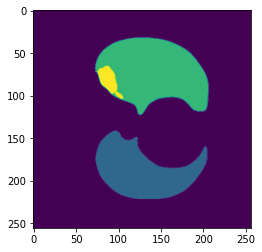

In [0]:
# load your data
# Path

images_Path = 'drive/My Drive/Dataset/Sample_Dataset/images/'
masks_Path = 'drive/My Drive/Dataset/Sample_Dataset/masks/'
test_Path  = 'drive/My Drive/Dataset/Sample_Dataset/test/'
masks_test_Path = 'drive/My Drive/Dataset/Sample_Dataset/mask_test/'

# List of files
#-------------------------------
images = os.listdir(images_Path)
masks = os.listdir(masks_Path)
test = os.listdir(test_Path)
masks_test = os.listdir(masks_test_Path)
#----------------------
IMG_Width  = 256
IMG_Height = 256
IMG_Channels = 1
#----------------------
def OneHotEncoding(im,n_classes):
  plt.imshow(im)
  one_hot = np.zeros((im.shape[0], im.shape[1], n_classes))
  for i, unique_value in enumerate(np.unique(im)):
    print(i-1, unique_value)
    one_hot[:, :, 1][im == unique_value] = 1
  return one_hot
#----------------------
X = np.zeros((len(images),IMG_Height,IMG_Width,IMG_Channels),dtype=np.uint8)
Y = np.zeros((len(masks),IMG_Height,IMG_Width,5),dtype=np.uint8)
X_test = np.zeros((len(test),IMG_Height,IMG_Width,IMG_Channels),dtype=np.uint8)
Y_test = np.zeros((len(masks_test),IMG_Height,IMG_Width,5),dtype=np.uint8)

for n, id_ in tqdm(enumerate(images), total=len(images)):   
    img = imread(images_Path + id_)  
    X[n][:,:,0] = img  #Fill empty X_train with values from img
    mask = imread(masks_Path+ id_)
    mask = OneHotEncoding(mask,5)   
    Y[n][:,:,:] = mask #Fill empty Y_train with values from mask
# Y = tf.keras.utils.to_categorical(Y, num_classes=4, dtype="uint8")

for n, id_2 in tqdm(enumerate(test), total=len(test)):   
    img = imread(test_Path + id_2)  
    X_test[n][:,:,0] = img  #Fill empty X_train with values from img
    mask2 = imread(masks_test_Path+ id_2) 
    mask2 = OneHotEncoding(mask2,5)  
    Y_test[n][:,:,:] = mask2 #Fill empty Y_train with values from mask

# Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=4, dtype="uint8")
# one channel to 3 channels
# X = np.stack([X,X,X],axis=2)  
# Y = np.stack([Y,Y,Y],axis=2)
# X_test = np.stack([X_test,X_test,X_test],axis=2) 

# Split Train Test Validate
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X_, Y_, test_size=0.1, random_state=42)
print('\nData Rreading, and Splitting Done!\n')
#----------------------------------------------------------------------------------------

### PreProcess the input, and define the model

In [0]:
# preprocess input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# define model
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.metrics import iou_score
from keras.layers import Input, Conv2D
from keras.models import Model

# define number of channels
N = X.shape[-1]

base_model = Unet(BACKBONE, classes=4, activation='softmax',
    encoder_weights='imagenet', encoder_freeze=False)
# ---------------------------------------------------------------
inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

# continue with usual steps: compile, fit, etc..
#----------------------------------------------------------------
# Loss


# loss = sm.losses.CategoricalCELoss()
loss = sm.losses.CategoricalFocalLoss()
opt = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
# Compile Model
model.compile(
    opt,
    loss=loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)],
)
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 3)     6         
_________________________________________________________________
model_16 (Model)             (None, None, None, 4)     24456589  
Total params: 24,456,595
Trainable params: 24,439,245
Non-trainable params: 17,350
_________________________________________________________________


### fit model
if you use data generator use `model.fit_generator(...)` instead of `model.fit(...)` 

more about `fit_generator` [here](https://keras.io/models/sequential/#fit_generator)

In [0]:
# import keras
# Model Checkpoint
# Callbacks = [
#              keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
             
#              keras.callbacks.ModelCheckpoint('Model.h5',
#               verbose=1, save_best_only=True) # monitor = 'val_acc', mode = 'auto',
#              ]# keras.callbacks.TensorBoard(log_dir='logs'),
             
model.fit(
   x=X_train,
   y=Y_train,
   batch_size=16,
   epochs=100,
   validation_data=(X_val, Y_val),
)

# Evaluate Model
#================
score = model.evaluate(X_test, Y_test, batch_size=100)
print('Test loss:', score[0])
print('Test accuracy', score[1])
#------------------------------------------------------
# Save Model
#================
model.save('my_model.h5')
# Delete Model
del model

Train on 34 samples, validate on 6 samples
Epoch 1/100
34/34 [==============================] - 16s 468ms/step - loss: 6.2980 - iou_score: 0.0354 - f1-score: 0.0634 - val_loss: 16.4429 - val_iou_score: 3.5628 - val_f1-score: 0.4672
Epoch 2/100
34/34 [==============================] - 2s 60ms/step - loss: 5.0420 - iou_score: 4.0236e-05 - f1-score: 8.0463e-05 - val_loss: 56.7860 - val_iou_score: 7.4491 - val_f1-score: 0.4838
Epoch 3/100
34/34 [==============================] - 2s 61ms/step - loss: 4.9607 - iou_score: 1.1124e-12 - f1-score: 1.1124e-12 - val_loss: 73.0614 - val_iou_score: 7.2043 - val_f1-score: 0.4832
Epoch 4/100
34/34 [==============================] - 2s 61ms/step - loss: 4.9515 - iou_score: 1.1726e-12 - f1-score: 1.1726e-12 - val_loss: 75.5470 - val_iou_score: 7.2311 - val_f1-score: 0.4833
Epoch 5/100
34/34 [==============================] - 2s 60ms/step - loss: 4.9458 - iou_score: 1.3779e-12 - f1-score: 1.3779e-12 - val_loss: 74.1193 - val_iou_score: 7.3389 - val_f1-sc

### Load Model

In [0]:
model = tf.keras.models.load_model("my_model.h5",compile=False)
model.compile( 'Adam',
    loss=loss,
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
#
score = model.evaluate(X_test, Y_test, batch_size=100, verbose=1)
print('Test loss:', score[0])
print('Test accuracy', score[1])
#
prediction = model.predict(X_test)

1/1 [==============================] - 0s 1ms/step - loss: 5.9089 - iou_score: 5.0339e-13 - f1-score: 5.0339e-13
Test loss: 5.90887451171875
Test accuracy 5.033883466315503e-13


### Visualize the Results

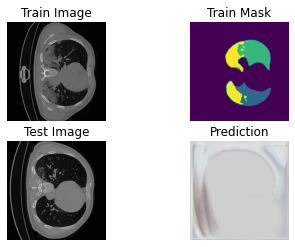

In [0]:
plt.figure(num='UNET Efficient Net B7')

plt.subplot('221')
plt.imshow(np.squeeze(X_train[1]),cmap='gray')
plt.title('Train Image')
plt.axis('off')

plt.subplot('222')
plt.imshow(np.squeeze(Y_train[1]))
plt.title('Train Mask')
plt.axis('off')

plt.subplot('223')
plt.imshow(np.squeeze(X_test[1]),cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot('224')
plt.imshow(np.squeeze(prediction[1]))
plt.title('Prediction')
plt.axis('off')

plt.show()